# Toy Examples of complex graph measures

In [285]:
import os
import cv2
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import scipy.sparse as sparse
import warnings
import random_graph
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.special import binom as nchoosek
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from skimage.transform.pyramids import pyramid_expand as expand
from skimage.transform.pyramids import pyramid_reduce as reduce
from matplotlib import gridspec
from matplotlib.colors import ListedColormap
from itertools import combinations

import pickle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


def save_to_disk(data, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)
def load_from_disk(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
        return data
    
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])
    


# Git Paths
OG_DATA_PATH = './'
GIT_DATA_PATH = './Data Exploration/'
GIT_PROCESSED_DATA_PATH = './Results/'
GIT_GRAPH_PATH = './Results/Graphs/'
RESSOURCES_PATH = './Ressources/' 

# load the city map image
white_bg_img = cv2.imread("./ressources/map_white.png")


# Global variables
fontsize = 20
fontweight = 'bold'
labelfontsize = 30
figurelabels = ['A','B','C','D']


green = [0.40,0.80,0.42]
blue = [0.27,0.38,0.99]
yellow = [0.96,0.73,0.23]
darkblue = [0.18, 0.19, 0.69]
lightyellow = [0.9763, 0.9831, 0.0538] 
grey = [0.75,0.75,0.75]
white = [1,1,1]
black = [0,0,0]

# implement parula color map scheme from matlab 
cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

plt.rcParams.update({'font.family':'Arial'})

# Partitioning Toy

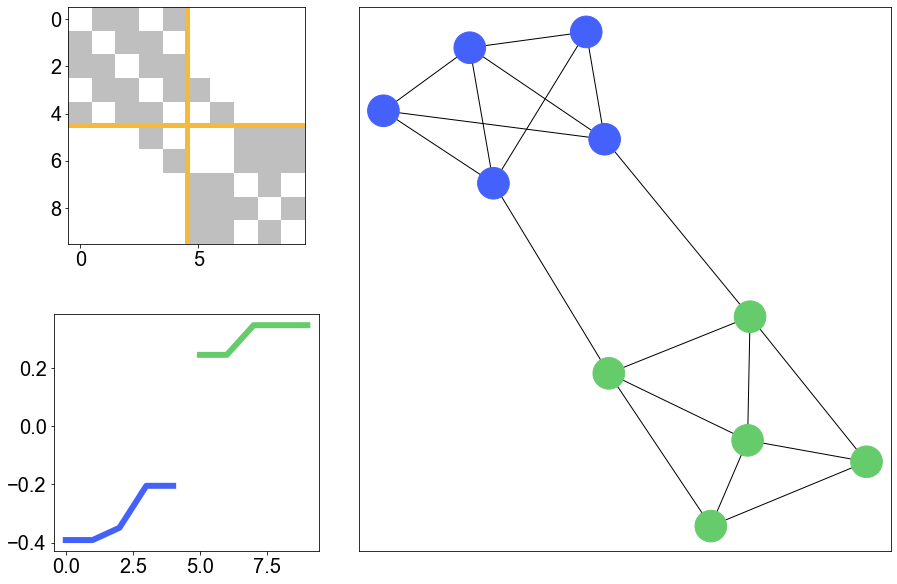

In [291]:
adj_matrix_cluster = np.array([[0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                               [1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                               [1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
                               [1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
                               [0, 1, 1, 1, 0, 0, 1, 0, 0, 0],
                               [0, 1, 0, 0, 0, 0, 0, 1, 1, 1],
                               [0, 0, 0, 0, 1, 0, 0, 1, 1, 1],
                               [0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
                               [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
                               [0, 0, 0, 0, 0, 1, 1, 0, 1, 0]])

G_cluster = nx.from_numpy_matrix(adj_matrix_cluster)


#plt.figure()
#nx.draw_networkx(G_cluster)

# get laplacian matrix and its eigenvalues + eigenvectors
laplacian_matrix = nx.laplacian_matrix(G_cluster)
laplacian_matrix = sparse.csr_matrix.toarray(laplacian_matrix)
# Eigenvalues and vectors
Eigenvalue, Eigenvector = np.linalg.eig(laplacian_matrix)
# sort Eigenvalues in ascending order and use index to sort eigenvectors
index_array = np.argsort(Eigenvalue)


Eigenvalue_2 = Eigenvalue[index_array[1]]
Eigenvector_2 = Eigenvector[:,index_array[1]]

vec_arg = np.argsort(Eigenvector_2)
vec_sort = np.sort(Eigenvector_2)

eig_pos = vec_sort[vec_sort>=0]
eig_neg = vec_sort[vec_sort<0]


colors = []
for i in Eigenvector_2: 
    if i >= 0: 
        colors.append(blue)
    else: 
        colors.append(green)
        
        

adj = sparse.csr_matrix.toarray(nx.adjacency_matrix(G, nodelist=vec_arg))


#plt.figure()
#nx.draw_networkx(G_cluster, node_color=colors)




figgy = plt.figure(figsize=(15,10))

# create grid for different subplots                    
gs = gridspec.GridSpec(ncols=2, nrows=2, 
                       width_ratios=[1, 2],
                       height_ratios=[1, 1],
                       wspace=0.1,
                       hspace=0.3)

ax1 = figgy.add_subplot(gs[0])
# spy matrix
node_colors = ListedColormap([white, grey])
plt.imshow(adj, cmap=node_colors)

plt.plot([9.5,-0.5],[4.5,4.5], color=yellow, linewidth=5)
plt.plot([4.5,4.5],[-0.5,9.5], color=yellow, linewidth=5)



ax2 = figgy.add_subplot(gs[0:, -1])
nx.draw_networkx(G_cluster, node_color=colors, node_size=1000, font_size=20, with_labels = False)



ax3 = figgy.add_subplot(gs[2])
plt.plot(range(len(eig_neg)), eig_neg, linewidth=6, color=blue)
plt.plot(range(len(eig_pos),len(vec_sort)), eig_pos, linewidth=6, color=green)

# Hierarchy Toy

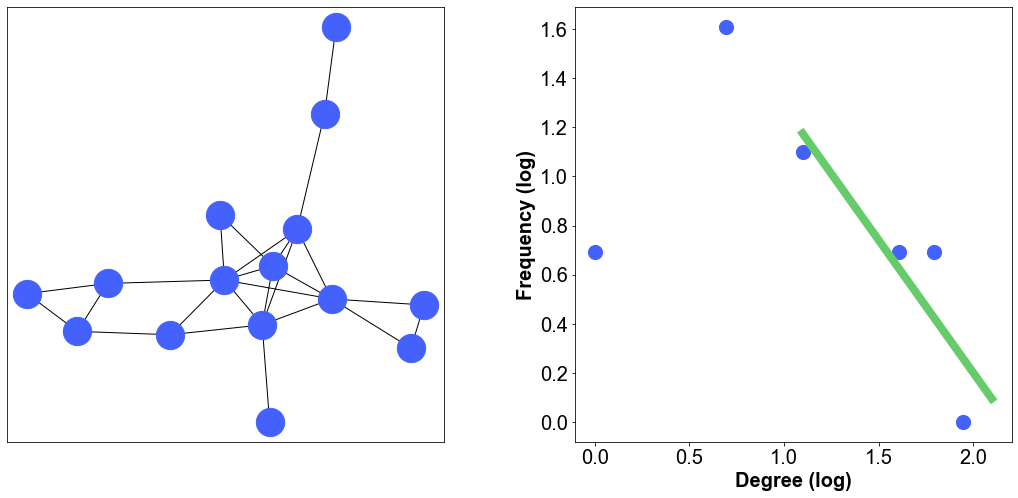

In [292]:
adj_matrix_hier = np.array([[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                            [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                            [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                            [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
                            [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
                            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                            [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
                            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

G_hier = nx.from_numpy_matrix(adj_matrix_hier)
 
degree_dict = dict(G_hier.degree)
degree_list = list(degree_dict.values())


median_degree = np.median(degree_list)

# get a list of unique degree values
UniqueDegree = np.unique(degree_list)
UniqueDegreeMed = UniqueDegree[UniqueDegree >= median_degree]

# get the frequency of each degree value
DegreeFrequency = dict()

for degree in UniqueDegree:
    DegreeFrequency[degree] = np.sum(degree_list==degree)

DegreeFrequencyMed = np.array(list(DegreeFrequency.values()))[UniqueDegree >= median_degree]

# do a linear fit of the log data of Unique Degree over Frequency
linear_model=np.polyfit(np.log(UniqueDegreeMed),np.log(DegreeFrequencyMed),1)
linear_model_fn=np.poly1d(linear_model)




figgy = plt.figure(figsize=(18,8))

gs = gridspec.GridSpec(ncols=2, nrows=1, 
                       width_ratios=[1, 1],
                       wspace=0.3)

figgy.add_subplot(gs[0])

nx.draw_networkx(G_hier, node_color=blue, node_size=800, font_size=15, with_labels=False)

figgy.add_subplot(gs[1])

plt.scatter(np.log(UniqueDegree),np.log(list(DegreeFrequency.values())), 200, color=blue)

x_s=np.arange(np.log(median_degree) ,max(np.log(UniqueDegree)+0.5))
plt.plot(x_s, linear_model_fn(x_s),color=green, linewidth=8)

# settings
plt.xlabel('Degree (log)', fontsize=fontsize, weight='bold')
plt.ylabel('Frequency (log)', fontsize=fontsize, weight='bold')
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)




# Rich Club Toy

In [224]:
adj_matrix_rich = np.array([[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                            [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                            [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                            [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
                            [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
                            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                            [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
                            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

G_rich = nx.from_numpy_matrix(adj_matrix_rich)
 
degree_dict = dict(G_rich.degree)
degree_list = list(degree_dict.values())

RC = nx.rich_club_coefficient(G_rich, normalized=False, seed=1)

# create a random graph for the rich club weighting with the same degree distribution
edges = random_graph.sample_simple_graph(degree_list)
randomG = nx.Graph()
randomG = nx.from_edgelist(edges)

# calculate the ric club for the random graph
RC_random = nx.rich_club_coefficient(randomG, normalized=False, seed=2)

RichClub = np.array(list(RC.values()))/np.array(list(RC_random.values()))

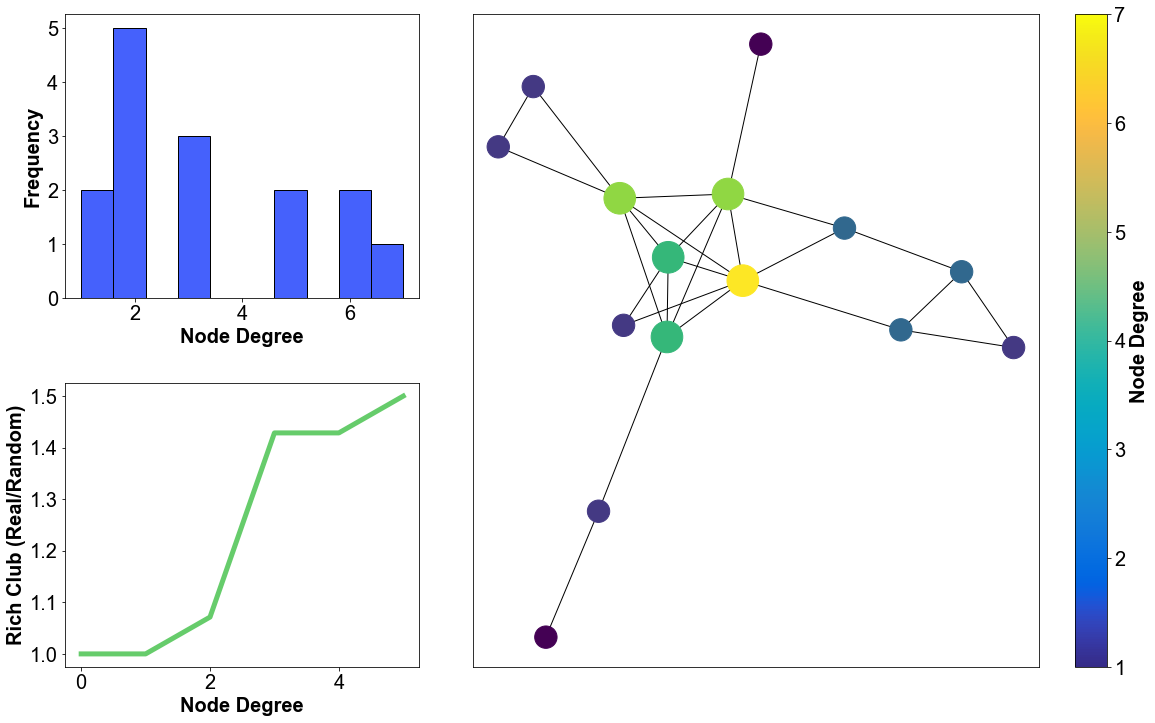

In [289]:
rich_color = [yellow,yellow,yellow,yellow,yellow,grey,grey,grey,grey,grey,grey,grey,grey,grey,grey]

node_size = [1000, 1000,1000,1000,1000,500,500,500,500,500,500,500,500,500,500]

figgy = plt.figure(figsize=(20,12))

gs = gridspec.GridSpec(ncols=2, nrows=2, 
                       width_ratios=[1, 2],
                       height_ratios=[1, 1],
                       wspace=0.1,
                       hspace=0.3)


ax1 = figgy.add_subplot(gs[0])
plt.hist(degree_list, color=blue, ec='k')
plt.xlabel('Node Degree', fontsize=20, weight='bold')
plt.ylabel('Frequency', fontsize=20, weight='bold')
ax1.tick_params(axis = 'both', which = 'major', labelsize = fontsize)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = fontsize)

ax2 = figgy.add_subplot(gs[0:, -1])
nx.draw_networkx(G_rich, node_color=degree_list, node_size=node_size, font_size=15, with_labels=False)

vmin = np.min(degree_list)
vmax = np.max(degree_list)
sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Node Degree', size=20, weight='bold')

ax3 = figgy.add_subplot(gs[2])
plt.plot(RichClub, color=green, linewidth=5)
plt.xlabel('Node Degree', fontsize=20, weight='bold')
plt.ylabel('Rich Club (Real/Random)', fontsize=20, weight='bold')
ax3.tick_params(axis = 'both', which = 'major', labelsize = fontsize)
ax3.tick_params(axis = 'both', which = 'minor', labelsize = fontsize)